# Progetto-Kidney-CT-Scan-Classification

## Import necessari e check sulla GPU

In [3]:
import pandas as pd # Importa la libreria pandas
import numpy as np # Importa la libreria numpy per calcoli numerici e operazioni con array
import os # Importa la libreria os per interagire con il sistema operativo (percorsi file)

import torch  # Importa la libreria PyTorch per il deep learning
import torch.nn as nn # Importa il modulo torch.nn contenente le implementazioni dei layer per le reti neurali
import torchvision # Importa il modulo torchvision per dataset e trasformazioni
import torchvision.transforms.functional as TF # Importa le funzioni di trasformazione da torchvision
from torchvision import models # Importa il modulo models da torchvision per i modelli pre-addestrati
from torch.utils.data import Dataset, DataLoader # Importa Dataset e DataLoader per la gestione dei dati nei batch
import torch.optim as optim # Importa gli ottimizzatori per l'allenamento delle reti neurali

from matplotlib import pyplot as plt # Importa matplotlib.pyplot per la creazione di visualizzazione di dati (esplorazione del dataset)
from PIL import Image # Importa PIL.Image per caricare e manipolare le immagini

from sklearn.model_selection import train_test_split # Importa la funzione train_test_split da sklearn.model_selection per dividere i dati in set di training e test
from sklearn.metrics import classification_report # Importa classification_report da sklearn.metrics per la valutazione della performance del modello
from sklearn.metrics import confusion_matrix # Importa la funzione confusion_matrix da sklearn.metrics per la valutazione della performance del modello attraverso matrici di confusione

import seaborn as sns # Importa la libreria seaborn per visualizzazioni di dati statistiche
import cv2 # Importa la libreria cv2 per la manipolazione di immagini

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Imposta il dispositivo su "cuda" se è disponibile una GPU, altrimenti su "cpu"
print(device) # Stampa il dispositivo di calcolo selezionato (CPU o GPU)

torch.manual_seed(42) # Imposta un seed casuale per la riproducibilità dei risultati


cuda


## Creazione del Dataframe 'data'

In [4]:
root_dir='/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone' # Definisce la directory principale
classes=os.listdir('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone') # Ottiene un elenco delle sottocartelle (le classi) presenti nella directory principale
data_list = [] # Crea una lista vuota per memorizzare i dati di ogni immagine
for cls in classes: # Itera su ogni sottocartella (classe)
      path = os.path.join(root_dir, cls) # Costruisce il percorso completo della sottocartella (classe)
      for img_name in os.listdir(path): # Itera su ogni immagine nella sottocartella (classe) corrente
          img = plt.imread(os.path.join(path, img_name))  # Legge l'immagine corrente
          data_list.append((os.path.join(path, img_name), classes.index(cls), cls, img.shape))  # Aggiunge alla lista `data_list` un elemento dati (tupla) per l'immagine corrente contenente:
                                                                                                #   - percorso completo del file immagine
                                                                                                #   - indice della classe
                                                                                                #   - nome della classe
                                                                                                #   - dimensione dell'immagine

In [5]:
data = pd.DataFrame(data_list, columns=['path', 'label','class','shape']) # Crea un DataFrame Pandas a partire dalla lista `data_list` con le seguenti colonne:
                                                                          #   - 'path': percorso completo del file immagine
                                                                          #   - 'label': indice della classe
                                                                          #   - 'class': nome della classe
                                                                          #   - 'shape': dimensione dell'immagine


In [8]:
data # Visualizza il contenuto del DataFrame `data`

,path,label,class,shape
0,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0,Tumor,"(622, 768, 3)"
1,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0,Tumor,"(701, 867, 3)"
2,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0,Tumor,"(512, 512, 3)"
3,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0,Tumor,"(714, 882, 3)"
4,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,0,Tumor,"(512, 512, 3)"
...,...,...,...,...
12441,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3,Cyst,"(512, 512, 3)"
12442,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3,Cyst,"(544, 672, 3)"
12443,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3,Cyst,"(545, 675, 3)"
12444,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,3,Cyst,"(512, 512, 3)"


## Analisi dei dati

In [7]:
data_count=data['class'].value_counts() # Calcola il numero di immagini per ogni classe
print(data_count) # Visualizza il numero di immagini per ogni classe

class
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


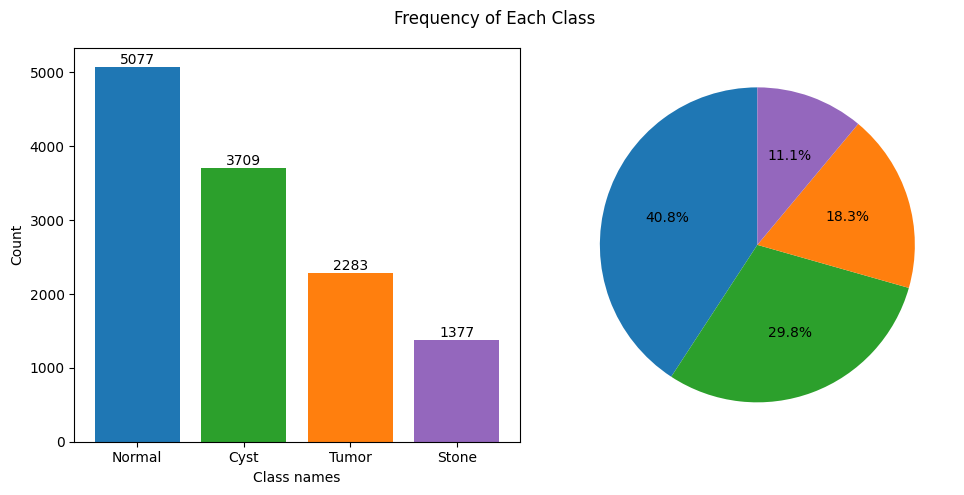

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) # Crea la figura e i subplot relativi alla frequenza di ogni classe

plot_bar=ax1.bar(data_count.index, data_count.values, color=['#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD']) # Crea un grafico a barre per visualizzare la distribuzione delle immagini per classe
                                                                                   # - `data_count.index`: etichette sull'asse x (nomi delle classi)
                                                                                   # - `data_count.values`: valori sull'asse y (numero di immagini per ogni classe)
                                                                                   # - `color`: lista di colori per le barre del grafico
ax1.set(xlabel='Class names', ylabel='Count') # Imposta le etichette degli assi
ax1.bar_label(plot_bar) # Aggiunge etichette di testo sopra alle barre del grafico


ax2.pie(data_count.values, autopct='%1.1f%%', startangle=90, colors=['#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD']) # Crea un grafico a torta

plt.suptitle('Frequency of Each Class') #Aggiuge il titolo alla figura
plt.tight_layout() # Layout per evitare sovrapposizioni
plt.show() # Visualizzazione del grafico


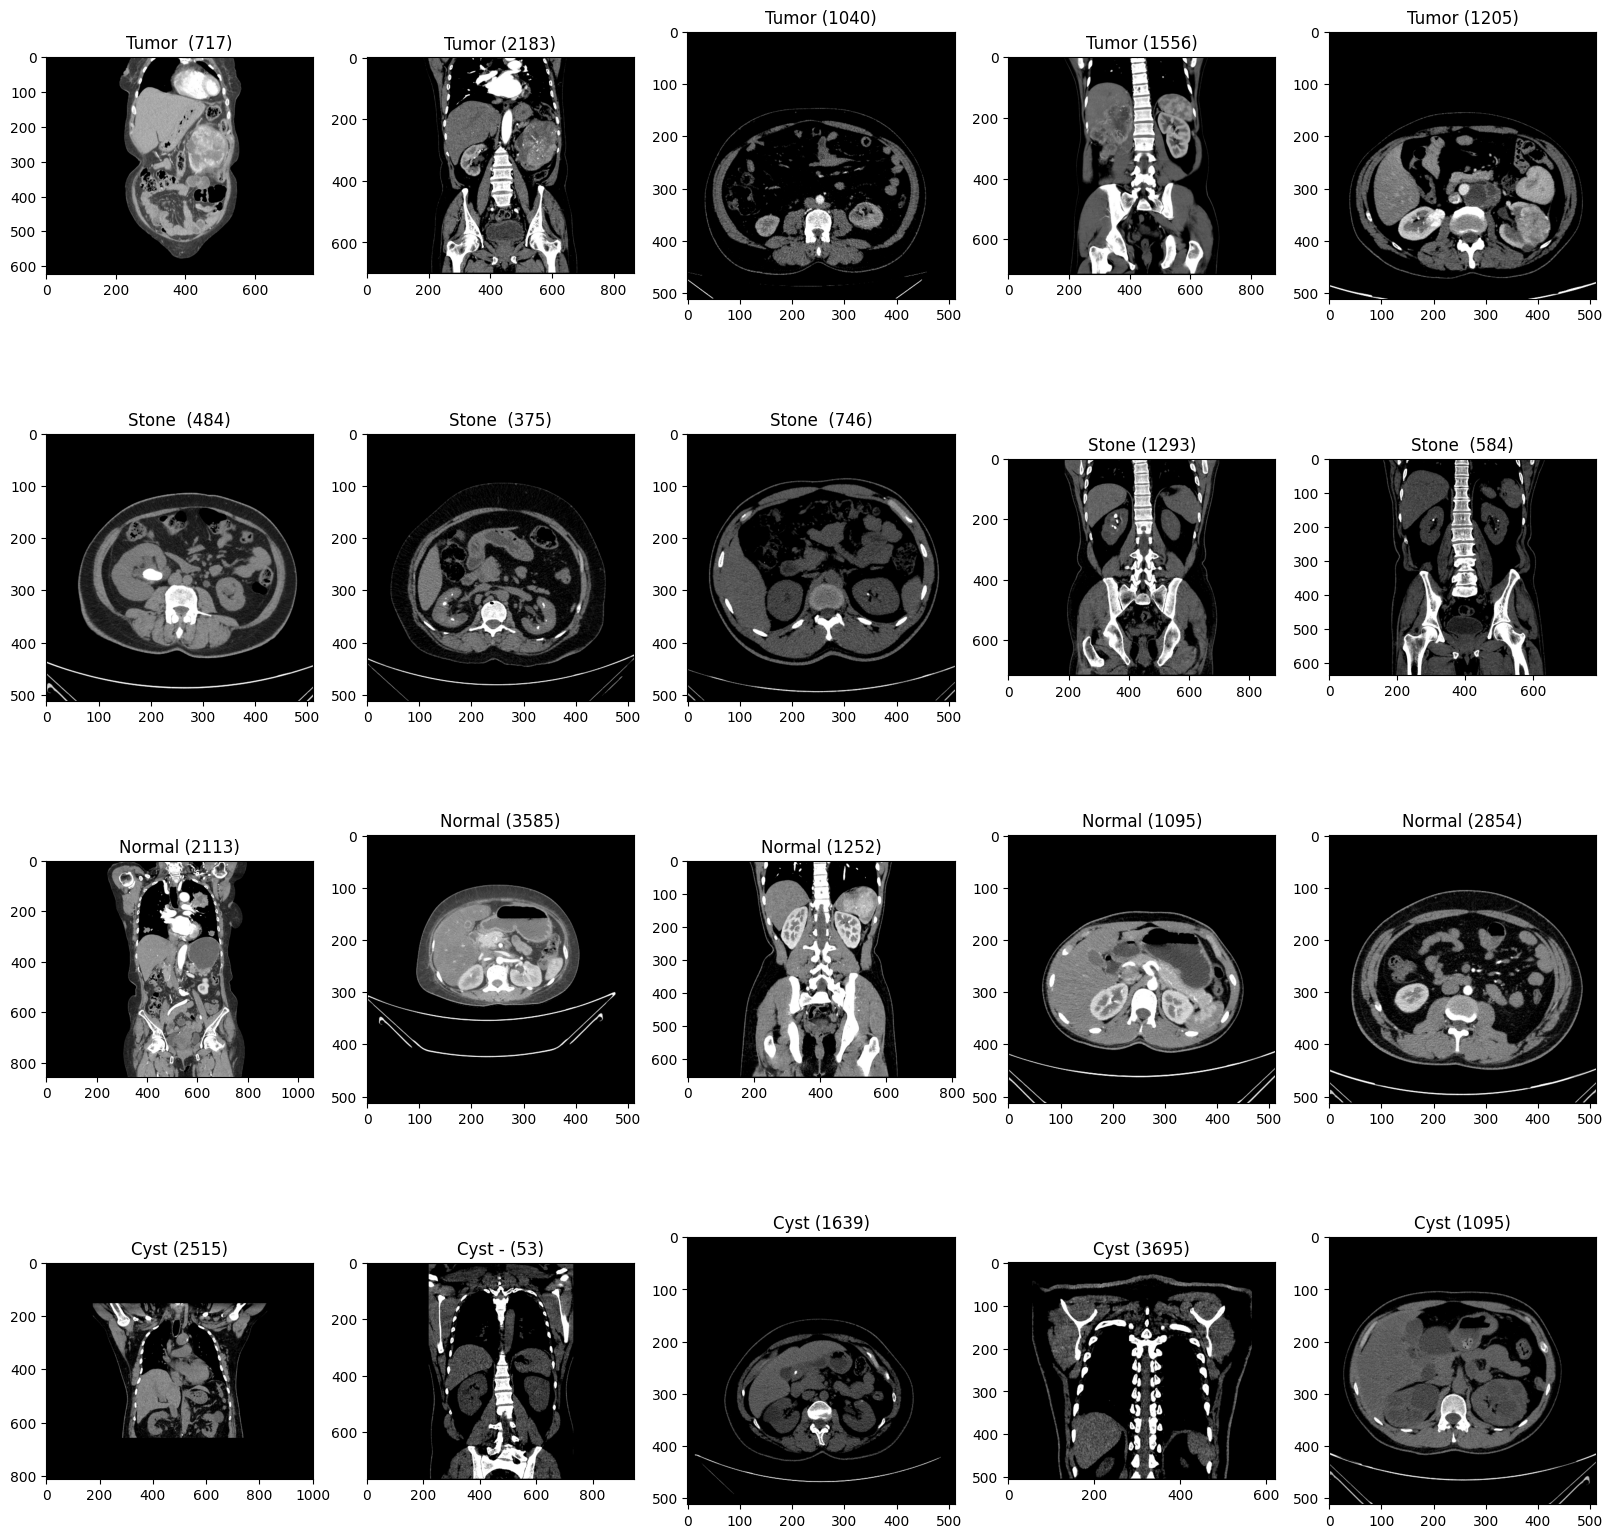

In [10]:
def plot_imgs(DataFrame):
  """
  Questa funzione crea una griglia di subplot 4x5 e visualizza le prime 5 immagini di ogni classe univoca presente nel DataFrame.

  - Argomenti in ingresso della funzione:
      DataFrame: Il DataFrame prima creato contenente i dati sulle immagini
  """

  fig, axs = plt.subplots(4, 5, figsize=(20,20)) # Crea una figura con una griglia di subplot (4x5)
  j=0 # Indice della riga dei subplot
  for i in DataFrame['class'].unique(): # Ciclo sulle classi uniche nel DataFrame
     k=0 # Indice della colonna dei subplot
     for img_path in data.loc[data['class']==i,'path'][:5].values: # Itera sui percorsi delle prime 5 immagini della classe corrente
        img=plt.imread(img_path) # Carica l'immagine dal percorso
        axs[j, k].imshow(img) # Visualizza l'immagine nel subplot corrente
        axs[j, k].set_title(i+' '+img_path[-10:-4]) # Imposta il titolo del subplot con il titolo dell'immagine (ottenuta estraendo la porzione finale del path dell'immagine stessa)
        k+=1 # Incrementa l'indice della colonna
     j+=1 # Incrementa l'indice della riga

plot_imgs(data)  # Utilizzo della suddetta funzione

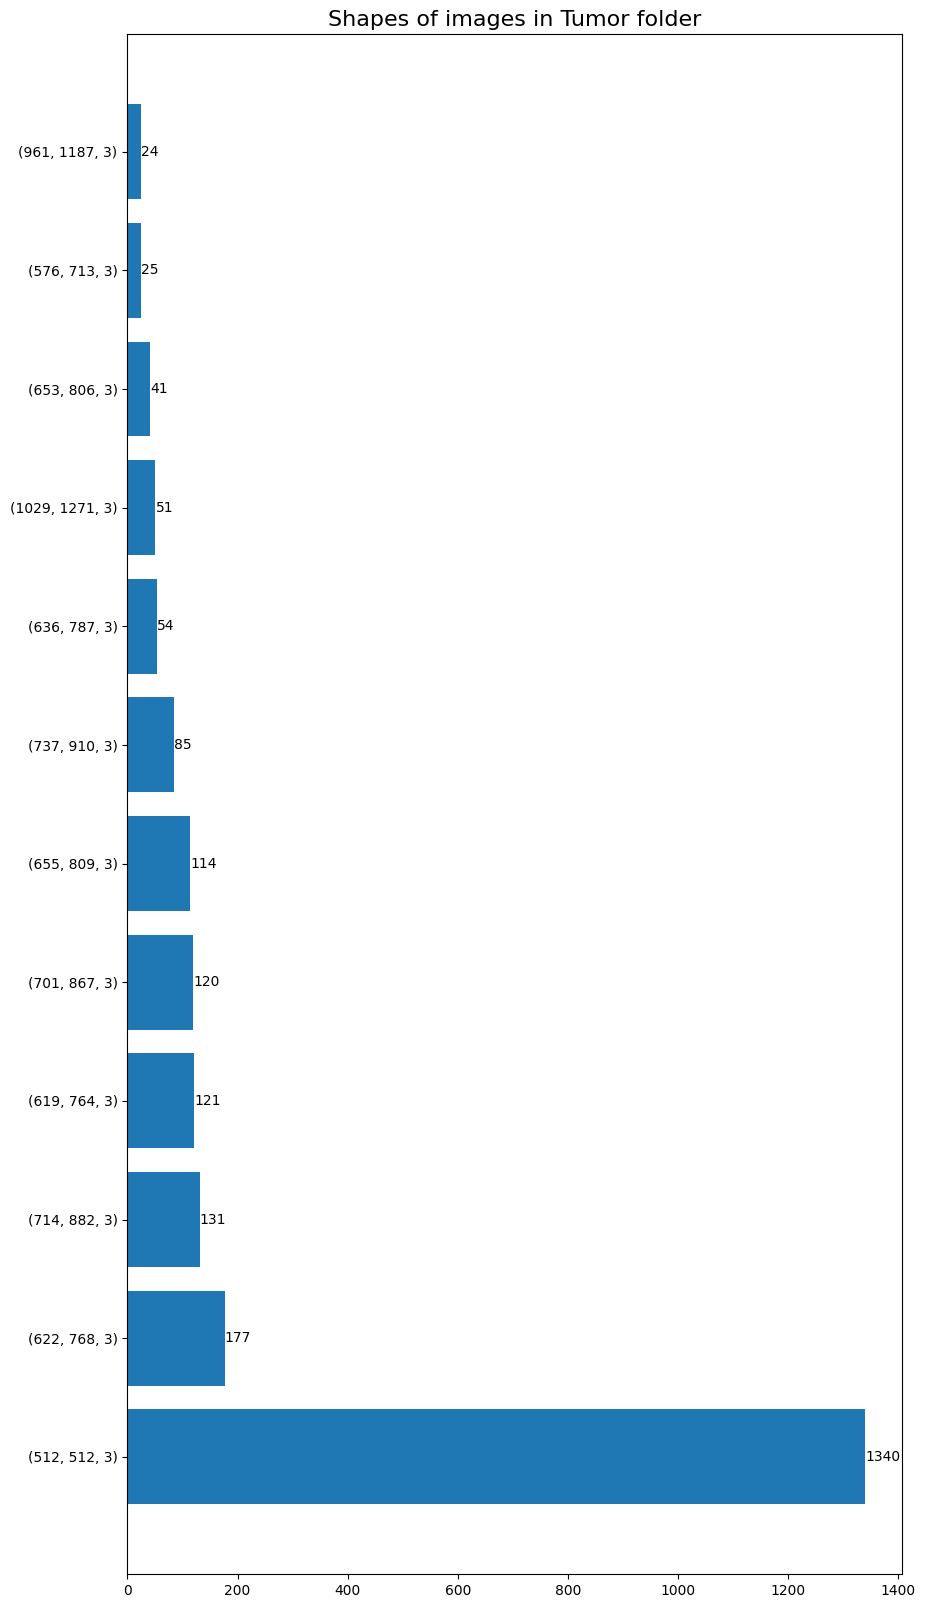

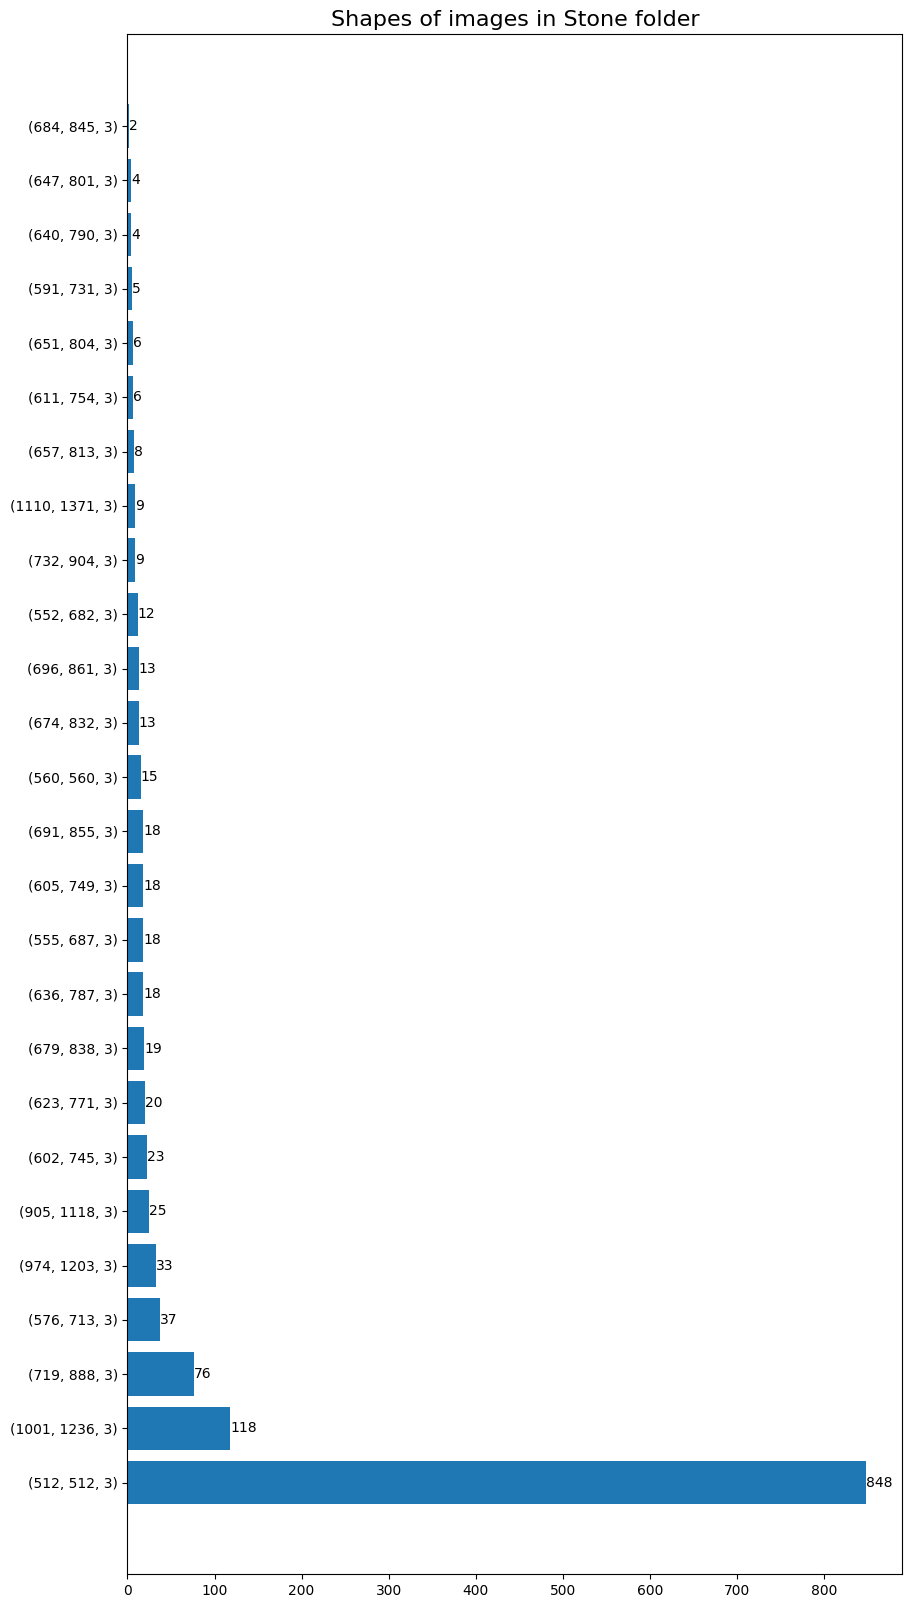

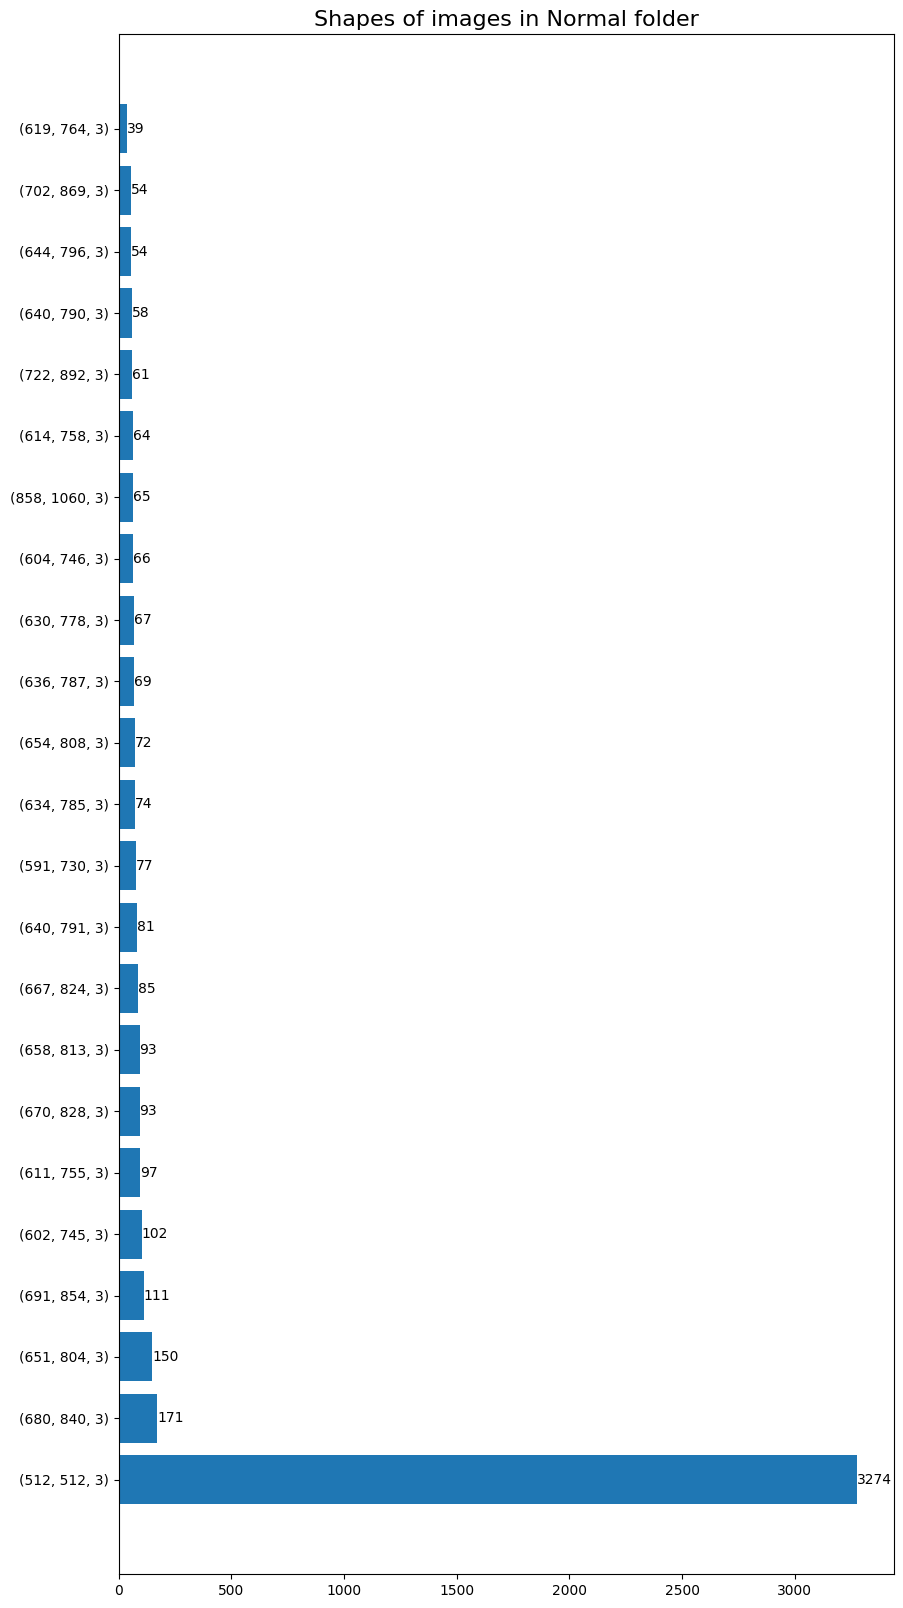

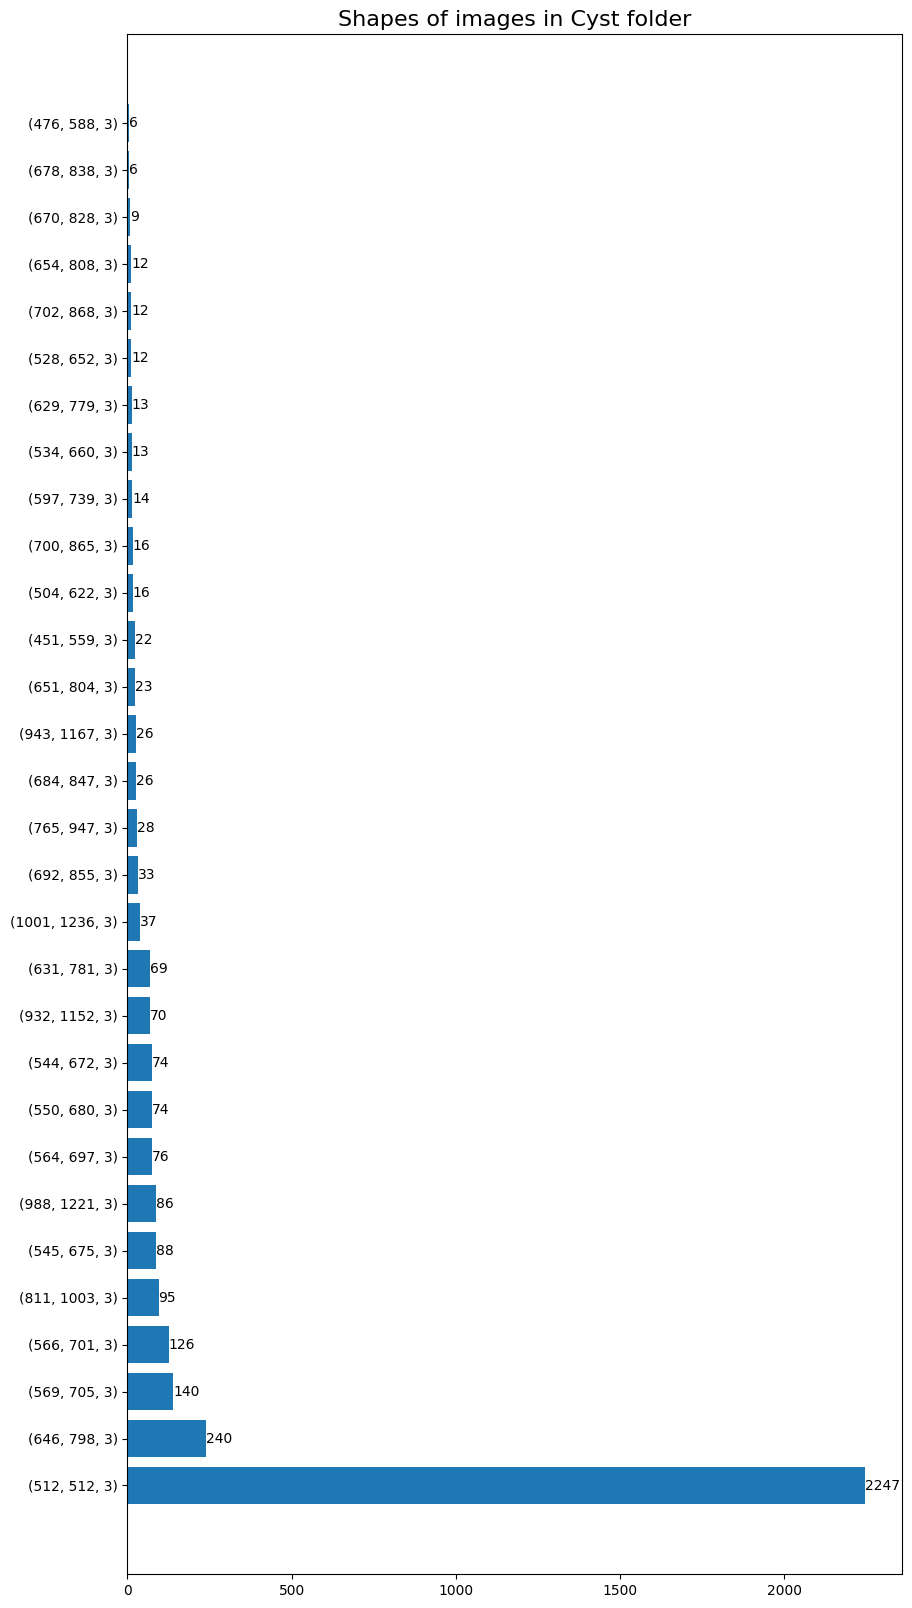

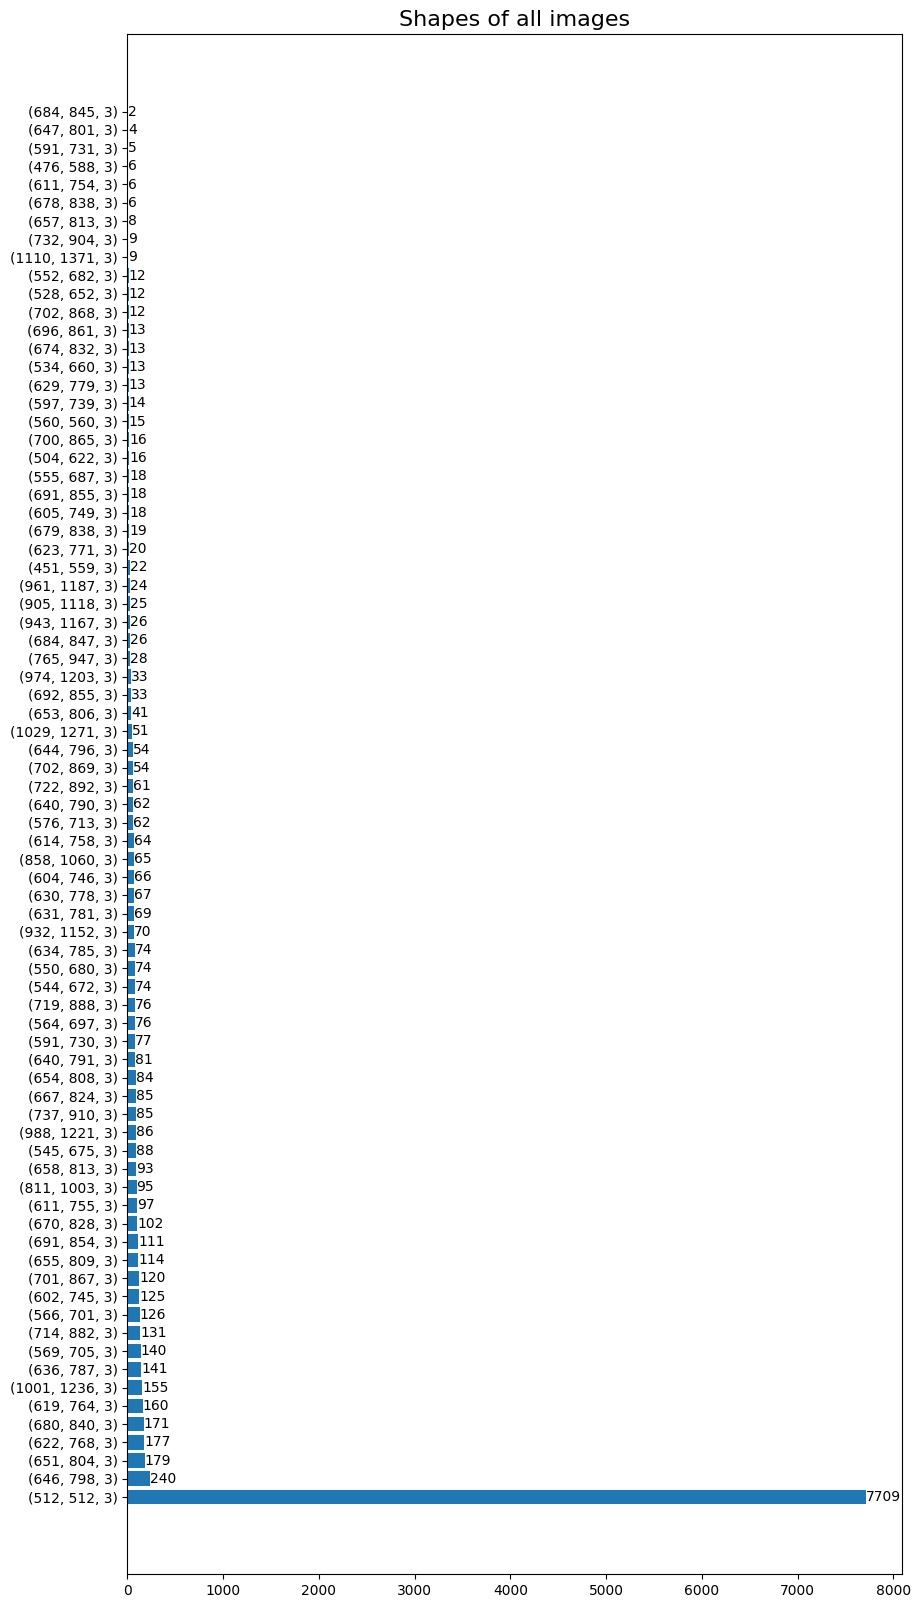

In [11]:
def size_imgs(DataFrame):
  """
  Questa funzione crea cinque figure delle quali quattro per visualizzare la distribuzione delle dimensioni delle immagini per ogni classe e una complessiva per tutte le immagini.

  - Argomenti in ingresso della funzione:
      DataFrame: Il DataFrame contenente i dati sulle immagini.
  """

  # fig, axs = plt.subplots(4, 1, figsize=(10,50))  # Crea una figura con una griglia di subplot (4x1) con dimensioni 10 x 50
  # j=0 # Indice per scorrere le righe dei subplot

  for i in DataFrame['class'].unique(): # Ciclo sulle classi uniche nel DataFrame
    plt.figure(figsize=(10, 20)) # Crea la figura i-esima con dimensioni 10 x 20
    data_count=DataFrame.loc[DataFrame['class']==i,'shape'].value_counts() # Filtra il DataFrame per le immagini della classe corrente "i" e conta le immagini per ogni dimensione 'shape'

    plot_barh = plt.barh(list(map(str, data_count.index)), data_count.values) # Crea un istogramma orizzontale che mostra la distribuzione dei conteggi per ogni dimensione della classe corrente
    plt.title(f'Shapes of images in {i} folder', fontsize=16) # Imposta il titolo della figura i-esima con il nome della classe corrente
    plt.bar_label(plot_barh) # Aggiunge le etichette di conteggio alle barre dell'istogramma
    plt.show() # Visualizza la figura

  plt.figure(figsize=(10, 20)) # Crea un'altra figura con dimensioni 10 x 20
  data_count = DataFrame['shape'].value_counts() # Calcola la distribuzione delle dimensioni per tutte le immagini del DataFrame
  plot_barh = plt.barh(list(map(str, data_count.index)), data_count.values) # Crea un istogramma orizzontale che mostra la distribuzione complessiva delle dimensioni
  plt.title(f'Shapes of all images', fontsize=16) # Imposta il titolo della figura
  plt.bar_label(plot_barh) # Aggiunge le etichette di conteggio alle barre dell'istogramma

size_imgs(data) # Utilizzo della suddetta funzione

In [12]:
print(f"Numero totale di dimensioni differenti delle immagini: {len(data['shape'].value_counts())}") # Stampa il numero totale di dimensioni presenti nel dataframe


Numero totale di dimensioni differenti delle immagini: 77


In [13]:
def min_max_intensity_check(DataFrame):
    '''
    Questa funzione identifica i valori massimi e minimi di intensità dei pixel per ogni immagine e controlla che
    tutte le immagini nel DataFrame abbiano lo stesso valore massimo e minimo.

    - Argomenti in ingresso della funzione:
        DataFrame: Il DataFrame contenente i dati sulle immagini.

    - Returns della funzione:
        min: valore minimo di intensità dei pixel di tutte le immagini
        max: valore massimo di intensità dei pixel di tutte le immagini
    '''

    # Inizializzazione variabili di controllo
    a = 0
    b = 0

    for i, path in enumerate(DataFrame['path']): # Ciclo per ogni immagine nel dataframe 'data'
        img = np.array(Image.open(path)) # Caricamento immagine

        if i == 0: # Controllo prima immagine
            # Impostazione valori massimi e minimi iniziali con quelli della prima immagine
            max = img.max()
            min = img.min()

        else: # Confronto valori massimi e minimi con le altre immagini

            if img.max() != max: # Se il valore massimo dell'immagine corrente è diverso dal massimo finora trovato
                a += 1 # Incremento contatore 'a'
                max = img.max() # Aggiornamento del valore massimo con quello dell'immagine corrente

            if img.min() != min: # Se il valore minimo dell'immagine corrente è diverso dal minimo finora trovato
                b += 1 # Incremento contatore 'b'
                min = img.min() # Aggiornamento del valore minimo con quello dell'immagine corrente

    if a != 0 or b != 0: # Controllo se ci sono differenze nei valori massimi e minimi
        print('Le immagini non hanno lo stesso valore massimo e minimo di intensità dei pixel')
    else:
        print('Le immagini hanno lo stesso valore massimo e minimo di intensità dei pixel')

    print(f'I valori di massimo e di minimo assoluto sono {max} e {min}') # Stampa valori massimi e minimi assoluti

    return min, max # Ritorna i valori min e max

min, max = min_max_intensity_check(data) # Utilizzo della suddetta funzione

Le immagini hanno lo stesso valore massimo e minimo di intensità dei pixel
I valori di massimo e di minimo assoluto sono 255 e 0


In [14]:
def plot_hist(img):
    """
    Questa funzione crea un istogramma cumulativo dell'intensità di pixel per un'immagine.

    - Argomenti in ingresso della funzione:
        img: Un array NumPy che rappresenta l'immagine.
    """

    (pdf, pdf_bins) = np.histogram(img, bins=max-min+1, density=True) # Calcola l'istogramma dell'intensità di pixel
    cumulative = np.cumsum(pdf) # Calcola l'istogramma cumulativo
    plt.plot(cumulative, 'r-') # Visualizza l'istogramma cumulativo



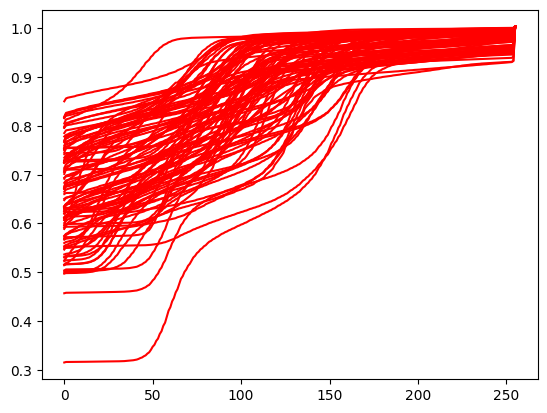

In [15]:
def plot_hist_imgs(DataFrame, n):
  """
  Funzione per visualizzare gli istogrammi di un campione di immagini

  - Argomenti in ingresso della funzione:
    DataFrame: Il DataFrame contenente i dati sulle immagini.
    n: Numero rappresentativo di campioni.
  """

  plt.plot(figsize=(10, 10))  # Imposta la dimensione della figura per il plot

  for img_path in DataFrame['path'].sample(frac=1).values[:n]: # Itera su n percorsi casuali
      img = cv2.imread(img_path) # Carica l'immagine dal percorso
      plot_hist(img) # Visualizza l'istogramma dell'immagine

  plt.show() # Mostra tutti gli istogrammi su un unico plot

plot_hist_imgs(data,100) # Utilizzo della suddetta funzione


In [16]:
def equalization(img):
  """
    Funzione per equalizzare l'istogramma di un'immagine

    - Argomenti in ingresso della funzione:
        img: immagine da equalizzare.
  """

  b, g, r = cv2.split(img) # Separa i canali BGR dell'immagine originale

  # Applica l'equalizzazione dell'istogramma a ciascun canale separatamente
  b_eq = cv2.equalizeHist(b)
  g_eq = cv2.equalizeHist(g)
  r_eq = cv2.equalizeHist(r)

  img_eq = cv2.merge([b_eq, g_eq, r_eq]) # Ricombina i canali equalizzati in un'immagine RGB

  return img_eq # Restituisce l'immagine equalizzata

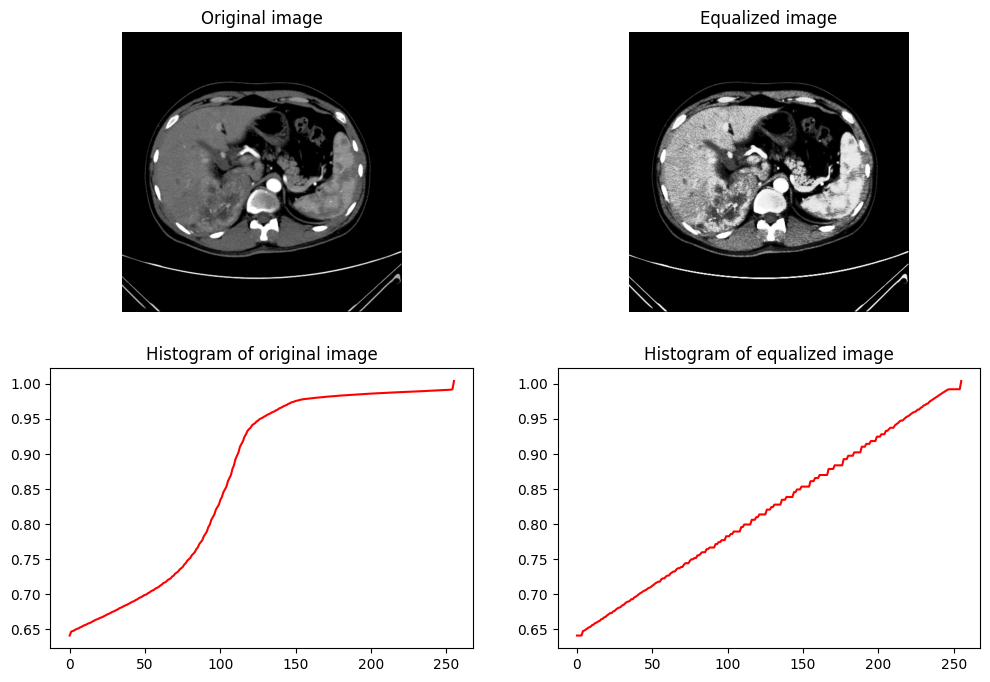

In [17]:
def compare_images(Dataframe, n):
    """
    Questa funzione confronta un'immagine originale con la sua versione equalizzata,
    mostrando le differenze visive e negli istogrammi.

    Argomenti:
        Dataframe: Un DataFrame contenente le immagini da confrontare.
        n: Indice della riga nel DataFrame che specifica l'immagine da utilizzare.
    """

    img_path = Dataframe['path'][n] # Ottiene il percorso dell'immagine dal DataFrame alla riga n
    img = cv2.imread(img_path) # Legge l'immagine dal percorso ottenuto
    img_eq = equalization(img) # Applica l'equalizzazione all'immagine

    plt.figure(figsize=(12, 8)) # Configura la dimensione della figura complessiva

    plt.subplot(2, 2, 1) # Crea il primo subplot
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Mostra l'immagine originale convertita in RGB
    plt.title('Original image') # Imposta il titolo del subplot
    plt.axis('off') # Disattiva gli assi per il subplot

    plt.subplot(2, 2, 2) # Crea il secondo subplot
    plt.imshow(cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)) # Mostra l'immagine equalizzata convertita in RGB
    plt.title('Equalized image') # Imposta il titolo del subplot
    plt.axis('off') # Disattiva gli assi per il subplot

    plt.subplot(2, 2, 3) # Crea il terzo subplot
    plot_hist(img) # Plotta l'istogramma dell'immagine originale
    plt.title('Histogram of original image') # Imposta il titolo del subplot

    plt.subplot(2, 2, 4) # Crea il quarto subplot
    plot_hist(img_eq) # Plotta l'istogramma dell'immagine equalizzata
    plt.title('Histogram of equalized image') # Imposta il titolo del subplot

    plt.show() # Mostra tutti i subplot

compare_images(data, 888) # Utilizzo della suddetta funzione



## Definizione del Dataset

In [18]:
class KidneyDataset(Dataset):
    """
    Dataset per caricare le immagini e le loro etichette.
    Questo dataset estende la classe `Dataset` di PyTorch per caricare, pre-processare e restituire le immagini e le loro etichette.
    Viene utilizzato per la classificazione di immagini.
    """


    def __init__(self, paths, labels):
        """
        Inizializza il dataset.

        - Argomenti in ingresso della funzione:
            paths: Percorsi delle immagini.
            labels: Etichette corrispondenti alle immagini.
        """
        self.paths = paths # Assegna i percorsi delle immagini alla variabile di istanza
        self.labels = labels # Assegna le etichette alla variabile di istanza


    def __len__(self):
        """
        Restituisce la dimensione del dataset (numero di immagini).

        - Returns della funzione:
            Numero di immagini nel dataset.
        """
        return len(self.paths)


    def transform(self, path, label):
        """
        Questa funzione trasforma un'immagine fandone il preprocessing e successivamente converte l'immagine e la sua etichetta in tensori.

        - Argomenti in ingresso della funzione:
            path: Percorso dell'immagine.
            label: Etichetta associata all'immagine.

        - Returns della funzione:
            image: Tensore contenente l'immagine trasformata
            label: Tensore contenente l'etichetta.
        """

        image = cv2.imread(path) # Carica l'immagine dal percorso specificato
        image = cv2.resize(image, (224, 224)) # Ridimensiona l'immagine a una dimensione standard (224x224 pixel)
        image = equalization(image) # Applica l'equalizzazione dell'istogramma all'immagine
        image = TF.to_tensor(image) # Converte l'immagine in un tensore di PyTorch
        label= torch.tensor(label) # Converte l'etichetta in un tensore di PyTorch

        return image, label


    def __getitem__(self, index):
        """
        Restituisce un'immagine e la sua etichetta dato un indice.

        - Argomenti in ingresso della funzione:
            index: Indice dell'immagine da restituire.

        - Returns della funzione:
            image: Tensore PyTorch che rappresenta l'immagine pre-processata.
            y: Tensore PyTorch che rappresenta l'etichetta dell'immagine.
        """

        # Recupera il percorso dell'immagine e l'etichetta dall'indice
        path = self.paths[index]
        label=self.labels[index]

        image,y=self.transform(path,label) # Applica la funzione transform

        return image, y

## Split dei dati e creazione dei DataLoader

In [19]:
# Estrae i percorsi delle immagini e le etichette dal dizionario 'data'
x = data['path'].values  # x contiene un array NumPy con i percorsi delle immagini
y = data['label'].values  # y contiene un array NumPy con le etichette

# Split dei dati in train e validation (90% train, 10% validation)
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.1, random_state=42)

train_dataset = KidneyDataset(X_train, Y_train) # Crea il dataset di training per il modello KidneyDataset
# Crea un dataloader per il training con batch size 32, rimescolamento (shuffle=True) ed eliminazione dell'ultimo batch incompleto (drop_last=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

valid_dataset = KidneyDataset(X_val, Y_val) # Crea il dataset di validation per il modello KidneyDataset
# Crea un dataloader per il validation con batch size 32 e rimescolamento (shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

## Modello ResNet50

In [20]:
# Caricamento del modello ResNet50 pre-addestrato su ImageNet
model_rn50 = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")

# Congelamento dei parametri del modello pre-addestrato per evitare che vengano aggiornati durante l'addestramento
for param in model_rn50.parameters(): # Iterazione su tutti i parametri del modello
    param.requires_grad = False # Blocco del calcolo del gradiente

# Sostituisce l'ultimo strato completamente connesso (fc) del modello pre-addestrato
model_rn50.fc = nn.Sequential(
    nn.Linear(2048, 128), # Primo strato lineare con 128 neuroni
    nn.ReLU(inplace=True), # Funzione di attivazione ReLU applicata in loco
    nn.Linear(128, 4), # Secondo strato lineare con 4 neuroni (uno per ogni classe)
)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


In [21]:
model_rn50 = model_rn50.float() # Converte tutti i parametri del modello in formato a virgola mobile a 32 bit (float).
model_rn50.to(device) # Sposta il modello sul dispositivo specificato (CPU o GPU)
print(model_rn50) # Stampa la struttura del modello
total_params = sum(p.numel() for p in model_rn50.parameters() if p.requires_grad) # Calcola il numero totale di parametri del modello che richiedono di essere addestrati
print('Numero di parametri:', total_params) # Stampa il numero totale di parametri che verranno aggiornati durante l'addestramento

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Modello VGG16

In [ ]:
# Carica il modello VGG16 pre-addestrato su ImageNet
model_vgg16 = models.vgg16(pretrained=True)

# Congela i parametri dei layer pre-addestrati per evitare aggiornamenti durante l'addestramento
for param in model_vgg16.parameters(): # Iterazione su tutti i parametri del modello
    param.requires_grad = False # Blocco del calcolo del gradiente

# Recupera il numero di neuroni in ingresso dell'ultimo strato lineare pre-addestrato
n_inputs = model_vgg16.classifier[6].in_features

# Definisce un nuovo classificatore da aggiungere
model_vgg16.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 128), # Primo strato lineare con 128 neuroni
            nn.ReLU(inplace=True), # Funzione di attivazione ReLU applicata in loco
            nn.Linear(128, 4), # Secondo strato lineare con 4 neuroni (uno per ogni classe)
            )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.0MB/s]


In [ ]:
model_vgg16 = model_vgg16.float() # Converte tutti i parametri del modello in formato a virgola mobile a 32 bit (float).
model_vgg16.to(device) # Sposta il modello sul dispositivo specificato (CPU o GPU)
print(model_vgg16) # Stampa la struttura del modello
total_params = sum(p.numel() for p in model_vgg16.parameters() if p.requires_grad) # Calcola il numero totale di parametri del modello che richiedono di essere addestrati
print('Numero di parametri:', total_params) # Stampa il numero totale di parametri che verranno aggiornati durante l'addestramento

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Definizione delle funzioni di addestramento e di visualizzazione dei risultati

In [22]:
def train(model, train_loader, loss_fn, optimizer, n):
    """
    Questa funzione di Training esegue un'epoca di addestramento sul modello.

    - Argomenti in ingresso della funzione:
        model: Il modello da allenare.
        train_loader: Il caricatore di dati di training.
        loss_fn: La funzione di perdita utilizzata per calcolare l'errore.
        optimizer: L'ottimizzatore utilizzato per aggiornare i pesi del modello.
        n: Il numero totale di campioni nel dataset di training.

    - Returns della funzione:
        La funzione ritorna una tupla contenente la precisione (corretto / totale) e la perdita media dell'epoca di training.
    """

    correct = 0 # Inizializza un contatore per le predizioni corrette
    losses = [] # Inizializza una lista per memorizzare le perdite di ogni batch
    model.train()  # Imposta il modello in modalità di training

    for x, y in train_loader: # Ciclo per scorrere i batch di dati e le relative etichette
        x = x.to(device)  # Sposta i dati di input sul dispositivo (CPU o GPU)
        y = y.to(device)  # Sposta le etichette sul dispositivo (CPU o GPU)

        # Calcolo della predizione e della perdita
        output = model(x)  # Esegue la predizione con il modello
        _, predict = torch.max(output, 1)  # Ottiene la classe con la probabilità più alta
        correct += torch.sum(predict == y)  # Accumula il numero di predizioni corrette
        loss = loss_fn(output, y)  # Calcola la perdita
        losses.append(loss.item())  # Accumula la perdita per ogni batch

        # Back-Propagation
        optimizer.zero_grad()  # Azzera i gradienti prima di ogni iterazione
        loss.backward()  # Backpropagation della perdita per aggiornare i gradienti
        optimizer.step()  # Aggiorna i pesi del modello utilizzando l'ottimizzatore
    lr_scheduler.step(np.mean(losses))   # Aggiorna il tasso di apprendimento in base alla perdita media

    return (correct.item() / n), np.mean(losses)  # Restituisce la precisione e la perdita media


In [23]:
def early_stopping(loss_values, best_loss, epochs_no_improve):
    """
    Funzione di Early Stopping per interrompere l'allenamento in anticipo se la perdita di
    validation non migliora per un numero specificato di epoche.

    - Argomenti in ingresso della funzione:
        loss_values : Il valore della perdita di validation per l'epoca corrente.
        best_loss: La migliore perdita di validation osservata finora.
        epochs_no_improve: Il numero di epoche consecutive in cui la perdita di validation non è migliorata.

    - Returns della funzione:
        best_loss:La migliore perdita di validation
        epochs_no_improve: Il numero di epoche consecutive senza miglioramento.
    """

    if loss_values < best_loss:  # Controlla se la perdita di validation corrente è inferiore alla migliore
        print(f"\nValid losses are less than the threshold:\t{best_loss}")

        best_loss = loss_values  # Aggiorna la migliore perdita di validation
        epochs_no_improve = 0  # Azzera il contatore di epoche senza miglioramento
        return best_loss, epochs_no_improve  # Ritorna i valori aggiornati
    else:
        epochs_no_improve += 1  # Incrementa il contatore di epoche senza miglioramento
        return best_loss, epochs_no_improve  # Ritorna i valori correnti

In [24]:
def validation(model, valid_loader, loss_fn, n):
    """
    Questa funzione valuta le prestazioni del modello.

    - Argomenti in ingresso della funzione:
        model: Il modello da valutare.
        valid_loader: Il dataloader di validation.
        loss_fn: La funzione di perdita utilizzata per calcolare l'errore.
        n: Il numero totale di campioni nel dataloader di validation.

    - Returns della funzione:
        L'accuratezza e la perdita media sulla serie di validation.
    """

    correct = 0  # Inizializza un contatore per le predizioni corrette
    losses = []  # Inizializza una lista per memorizzare le perdite di ogni batch
    model.eval()  # Imposta il modello in modalità di valutazione

    with torch.no_grad():  # Disabilita il calcolo del gradiente per la validation
        for x, y in valid_loader: # Iterazione sui dati di validation
            x = x.to(device)  # Sposta i dati di input sul dispositivo (CPU o GPU)
            y = y.to(device)  # Sposta le etichette sul dispositivo (CPU o GPU)

            # Calcolo della predizione e della perdita
            output = model(x)  # Esegue la predizione con il modello
            _, predict = torch.max(output, 1)  # Ottiene la classe con la probabilità più alta
            correct += torch.sum(predict == y)  # Accumula il numero di predizioni corrette

            loss = loss_fn(output, y)  # Calcola la perdita
            losses.append(loss.item())  # Aggiunge la perdita per ogni batch alla lista losses

    return (correct.item() / n), np.mean(losses)  # Restituisce l'accuratezza e la perdita media


In [25]:
def fit(model, loss_fn, optimizer, EPOCHS):
    """
    Questa funzione ottimizza i parametri del modello per minimizzare l'errore sulla serie di training
    e valuta le prestazioni del modello sulla serie di validation.

    - Argomenti in ingresso della funzione:
        model: Il modello da fittare.
        loss_fn: La funzione di perdita utilizzata per calcolare l'errore.
        optimizer: L'ottimizzatore utilizzato per aggiornare i pesi del modello.
        EPOCHS: Il numero di epoche di fitting.

    - Returns della funzione:
            - loss_train: Perdita media sul train set per ogni epoca.
            - loss_valid: Perdita media sul validation set per ogni epoca.
            - acc_train: Accuratezza sul train set per ogni epoca.
            - acc_valid: Accuratezza sul validation set per ogni epoca.
    """

    losses_train, losses_valid, acc_train, acc_valid = ([] for i in range(4))  # Inizializza liste vuote
    patience = 5  # Pazienza per l'early stopping
    best_loss = 999  # Migliore perdita osservata finora (inizializzata con un valore alto)
    epochs_no_improve = 0  # Numero di epoche consecutive senza miglioramento in validation loss

    for e in range(EPOCHS):  # Iterazione sul numero di epoche specificato

        # Fase di Training su un'epoca
        train_c, train_l = train(model, train_loader, loss_fn, optimizer, len(train_loader.sampler)) # Esegue la funzione di Training
        print(f"\nEpoch {e + 1} --- train accuracy {train_c * 100:.3f}    train losses {train_l:.3f}", end='') #Stampa l'epoca, l'accuratezza e la perdita del train correnti

        # Fase di Validation su un'epoca
        val_c, val_l = validation(model, valid_loader, loss_fn, len(valid_loader.sampler)) # Esegue la funzione di Validation
        print(f" --- valid accuracy {val_c * 100:.3f}   valid losses {val_l:.3f}") #Stampa l'epoca, l'accuratezza e la perdita del validation correnti

        # Early stopping
        best_loss, epochs_no_improve = early_stopping(loss_values=val_l, best_loss=best_loss, epochs_no_improve=epochs_no_improve)
        if epochs_no_improve == patience: # Controllo del raggiungento del numero di epoche di pazienza
            print("\nInterruzione anticipata per mancato miglioramento della validation loss")
            break  # Interrompe l'allenamento se non ci sono miglioramenti in validation loss per 'patience' numero di epoche

        acc_train.append(train_c)  # Aggiunge l'accuratezza di training alla lista delle accuratezze di training
        acc_valid.append(val_c)  # Aggiunge l'accuratezza di validation alla lista delle accuratezze di validation
        losses_train.append(train_l)  # Aggiunge la perdita di training alla lista delle perdite di training
        losses_valid.append(val_l)  # Aggiunge la perdita di validation alla lista delle perdite di validation

    return  acc_train, acc_valid, losses_train, losses_valid # Restituisce le liste con le metriche di training e validation


In [26]:
def plotplz(list1, list2=None, models=False):
    """
    Questa funzione crea due subplot che mostrano l'andamento dell'accuratezza (train e validation)
    e della loss (train e validation) di uno o due modelli durante l'addestramento.

    Argomenti in ingresso della funzione:
        list1: Una lista contenente le metriche (accuracy e loss) del primo modello.
        list2: Una lista contenente le metriche (accuracy e loss) del secondo modello. Se non fornita, verrà plottato solo il primo modello.
        models: Se False confronta il modello equalizzato e non. Se True confronta due modelli equalizzati diversi (rn50 e vgg16).
    """


    fig, axs = plt.subplots(1, 2, figsize=(12, 5)) # Crea una figura con due subplot e imposta la dimensione della figura


    metrics = ['Accuracy', 'Loss'] # Definisce le etichette per le metriche (accuratezza e loss)

    if models == False: # Controlla se il parametro models è False
        labels = ['eq train', 'no eq train', 'eq val', 'no eq val'] # Etichette per le linee se il parametro models è False
    else:
        labels = ['rn50 train', 'vgg16 train', 'rn50 val', 'vgg16 val']  # Etichette per le linee se il parametro models è True

    for i in range(2):  # Itera sui due subplot
        axs[i].plot(list1[i * 2], label=labels[0])  # Plotta i dati di training del primo modello
        axs[i].plot(list1[i * 2 + 1], label=labels[2])  # Plotta i dati di validazione del primo modello

        if list2 is not None:  # Se la seconda lista è fornita
            axs[i].plot(list2[i * 2], label=labels[1])  # Plotta i dati di training del secondo modello
            axs[i].plot(list2[i * 2 + 1], label=labels[3])  # Plotta i dati di validazione del secondo modello

        axs[i].set_xlabel("Iterations")  # Imposta l'etichetta per l'asse x (iterazioni)
        axs[i].set_ylabel(metrics[i])  # Imposta l'etichetta per l'asse y
        axs[i].legend()  # Aggiunge la legenda per le linee

    plt.tight_layout()  # Migliora la disposizione degli elementi nella figura
    plt.show()  # Visualizza la figura

In [27]:
def show_metrics(model,dataloader):
    """
    Questa funzione valuta le prestazioni di un modello su un dataloader di validation e
    genera una matrice di confusione e un report di classificazione.

    Argomenti in ingresso della funzione:
        model: Il modello da valutare.
        dataloader: Il DataLoader che fornisce i dati di validation.

    """
    model.eval() # Mette il modello in modalità valutazione

    all_preds = [] # Inizializzazione della lista per raccogliere le predizioni durante la valutazione
    all_labels = [] # Inizializzazione della lista per raccogliere le etichette durante la valutazione


    with torch.no_grad(): # Disabilita il calcolo del gradiente per migliorare la performance durante la valutazione
        for inputs, labels in dataloader: # Ciclo sui dati del dataloader
            inputs, labels = inputs.to(device), labels.to(device) # Sposta input e label sul dispositivo (CPU o GPU)
            outputs = model(inputs) # Ottiene le uscite del modello
            _, preds = torch.max(outputs, 1) # Ottiene la classe con la probabilità più alta

            # Aggiunge le predizioni e le label corrette alle liste corrispondenti
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())



    # Heatmap della matrice di confusione
    conf_matrix = confusion_matrix(all_labels, all_preds) # Calcola la matrice di confusione con le label e le predizioni

    plt.figure(figsize=(10, 8)) # Crea una figura con dimensioni 10x8

    # Crea un heatmap abilitando l'annotazione delle celle con i valori, indicando un formato di output per i valori intero ('d'), con colore blue e specifando il nome delle etichette delle x e delle y
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Tumor','Stone','Normal','Cyst'], yticklabels=['Tumor','Stone','Normal','Cyst'])
    plt.ylabel('True') # Aggiunge l'etichetta all'asse y
    plt.title('Confusion Matrix') # Aggiunge il titolo alla figura
    plt.savefig('confusion_matrix.png') # Salva la figura come PNG
    plt.show() # Visualizza la figura

    class_report = classification_report(all_labels, all_preds, output_dict=True) # Generazione del report di classificazione
    print(classification_report(all_labels, all_preds)) # Stampa il report di classificazione



## Addestramento dei modelli e risultati ottenuti


Epoch 1 --- train accuracy 66.137    train losses 0.925 --- valid accuracy 77.189   valid losses 0.695

Valid losses are less than the threshold:	999

Epoch 2 --- train accuracy 81.011    train losses 0.566 --- valid accuracy 84.578   valid losses 0.487

Valid losses are less than the threshold:	0.6946529027743217

Epoch 3 --- train accuracy 86.492    train losses 0.431 --- valid accuracy 87.631   valid losses 0.388

Valid losses are less than the threshold:	0.4865504847123073

Epoch 4 --- train accuracy 89.492    train losses 0.344 --- valid accuracy 91.165   valid losses 0.314

Valid losses are less than the threshold:	0.38814616967470217

Epoch 5 --- train accuracy 90.983    train losses 0.289 --- valid accuracy 91.566   valid losses 0.269

Valid losses are less than the threshold:	0.3142304703211173

Epoch 6 --- train accuracy 92.519    train losses 0.250 --- valid accuracy 93.896   valid losses 0.224

Valid losses are less than the threshold:	0.26919612976220936

Epoch 7 --- trai

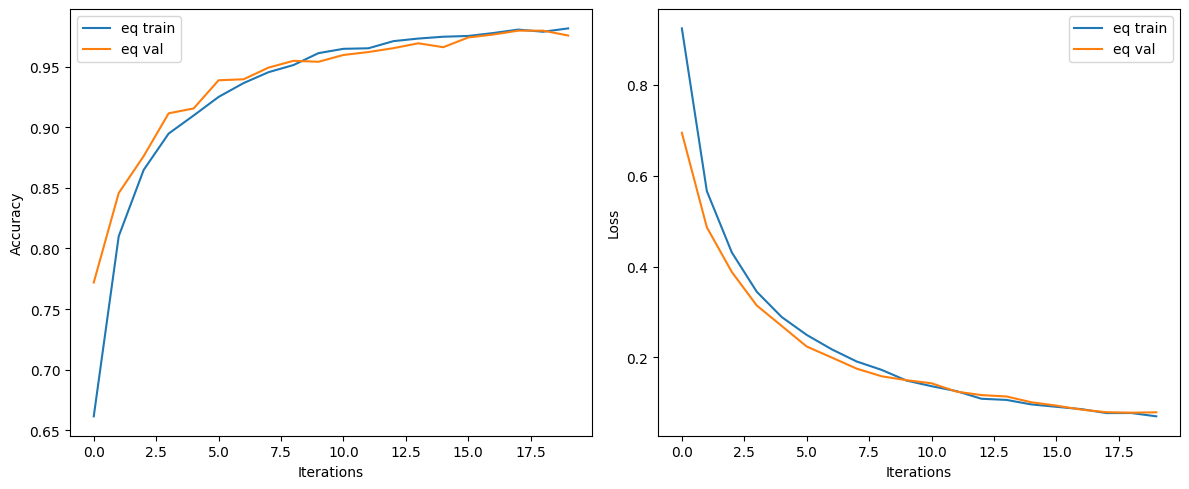

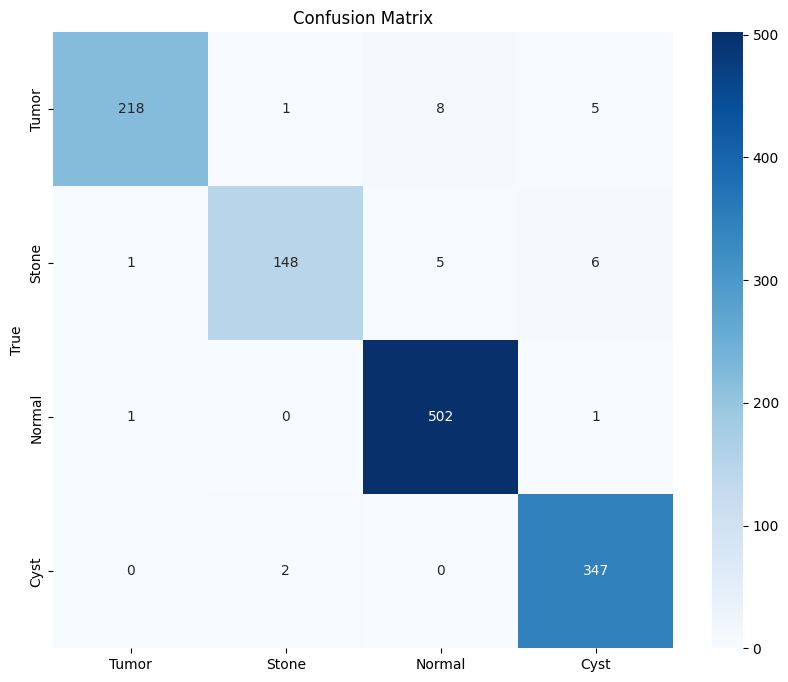

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       232
           1       0.98      0.93      0.95       160
           2       0.97      1.00      0.99       504
           3       0.97      0.99      0.98       349

    accuracy                           0.98      1245
   macro avg       0.98      0.96      0.97      1245
weighted avg       0.98      0.98      0.98      1245



In [28]:
loss_fn = nn.CrossEntropyLoss().to(device) # Definisce la funzione di perdita come CrossEntropyLoss e la sposta sul dispositivo (CPU o GPU)
optimizer = torch.optim.Adam(model_rn50.parameters(), lr=1e-4) # Definisce l'ottimizzatore Adam con parametro di apprendimento (Learning Rate "lr") di 1e-4 sui parametri del modello
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3)  # Definisce lo Scheduler che riduce automaticamente il learning rate se la loss non migliora per 3 epoche consecutive.

acc_train, acc_valid, losses_train, losses_valid = fit(model_rn50, loss_fn, optimizer, 20) # Addestra il modello resnet50 per 20 epoche e ritorna le liste di loss e di accuracy per training e validation

performance_rn50_eq=[acc_train, acc_valid, losses_train, losses_valid] # lista dei parametri

plotplz(performance_rn50_eq) # Richiama la funzione plotplz per visualizzare i grafici
show_metrics(model_rn50,valid_loader) #Richiama la funzione show_metrics

# Percorsi del file su Google Drive
drive_paths_eq = ['/content/drive/My Drive/acc_train_rn50_eq.txt','/content/drive/My Drive/acc_valid_rn50_eq.txt','/content/drive/My Drive/losses_train_rn50_eq.txt','/content/drive/My Drive/losses_valid_rn50_eq.txt']
drive_paths = ['/content/drive/My Drive/acc_train_rn50.txt','/content/drive/My Drive/acc_valid_rn50.txt','/content/drive/My Drive/losses_train_rn50.txt','/content/drive/My Drive/losses_valid_rn50.txt']

# Salva le performance in file di testo
for i, path in enumerate(drive_paths_eq):  # Itera sui percorsi dei file con equalizzazione e i loro indici
  with open(path, 'w') as f:  # Apre il file corrispondente in modalità scrittura
    for element in performance_rn50_eq[i]:  # Itera sugli elementi della lista di performance corrispondente
      f.write(f"{element}\n")  # Scrive ciascun elemento su una nuova riga del file


In [31]:
performance_rn50=[]
for path in drive_paths:  # Itera sui percorsi dei file
    with open(path, 'r') as f:  # Apre il file in modalità lettura
        lines = f.readlines()  # Legge tutte le linee del file
        performance_rn50.append([float(line.strip()) for line in lines])


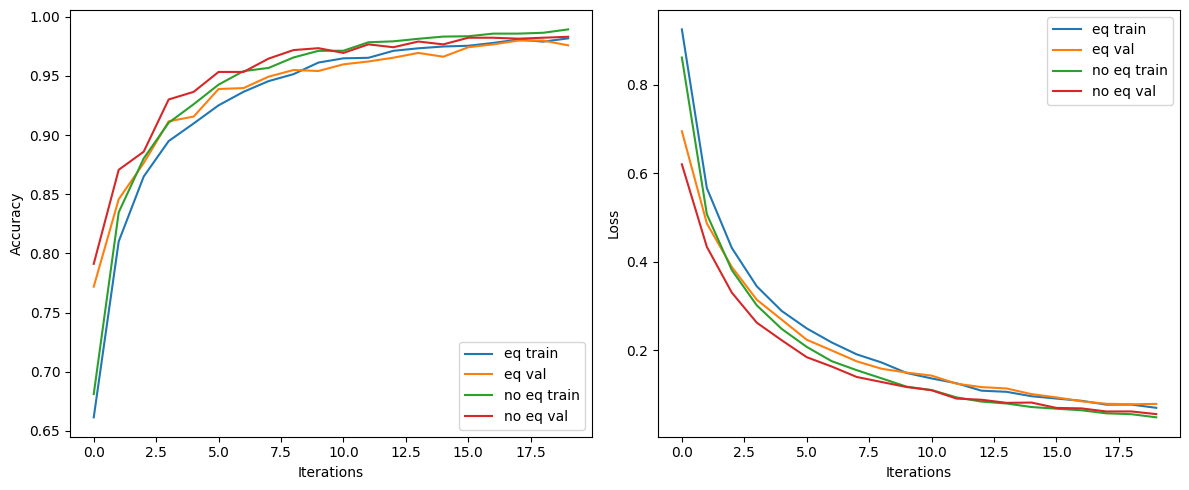

In [32]:
plotplz(performance_rn50_eq,performance_rn50) # Richiama la funzione plotplz per visualizzare i grafici del modello resnet50 equalizzato e non


Epoch 1 --- train accuracy 72.467    train losses 0.755 --- valid accuracy 80.643   valid losses 0.529

Valid losses are less than the threshold:	999

Epoch 2 --- train accuracy 81.564    train losses 0.509 --- valid accuracy 86.747   valid losses 0.403

Valid losses are less than the threshold:	0.5294931821334057

Epoch 3 --- train accuracy 84.287    train losses 0.438 --- valid accuracy 89.317   valid losses 0.336

Valid losses are less than the threshold:	0.4029391843539018

Epoch 4 --- train accuracy 85.573    train losses 0.401 --- valid accuracy 92.932   valid losses 0.280

Valid losses are less than the threshold:	0.33620720299390644

Epoch 5 --- train accuracy 86.457    train losses 0.371 --- valid accuracy 93.574   valid losses 0.253

Valid losses are less than the threshold:	0.279595360541955

Epoch 6 --- train accuracy 87.537    train losses 0.350 --- valid accuracy 93.414   valid losses 0.228

Valid losses are less than the threshold:	0.25291061248534763

Epoch 7 --- train

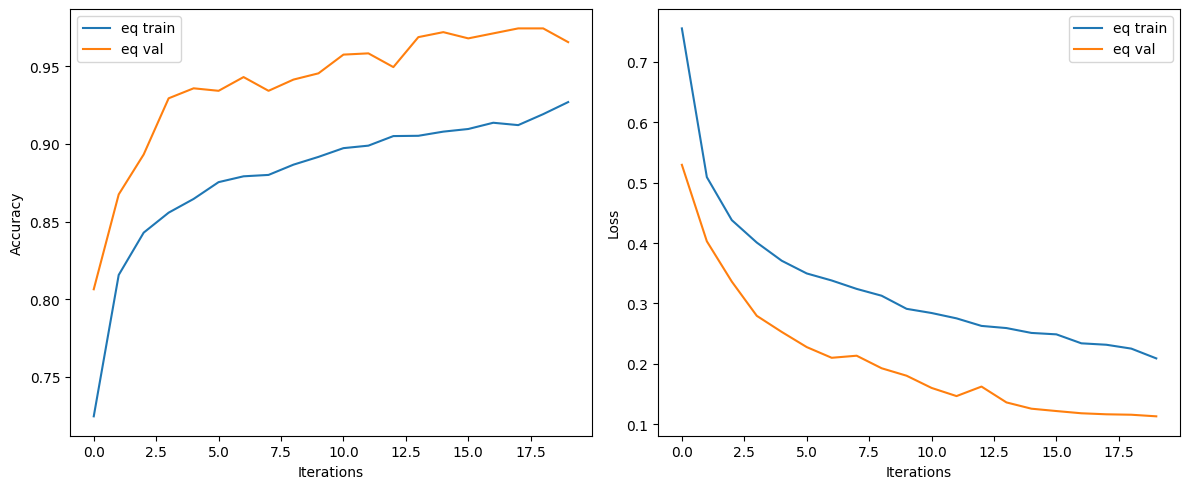

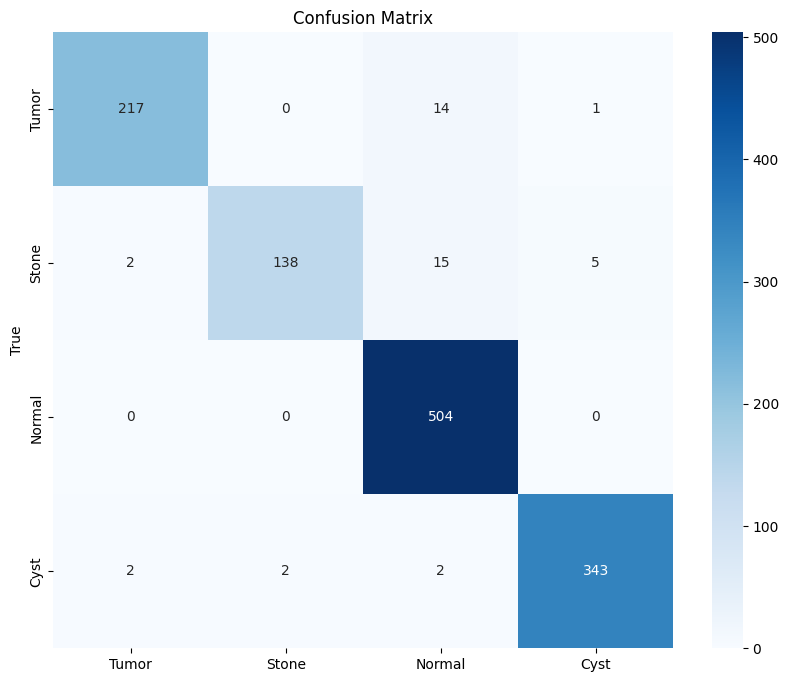

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       232
           1       0.99      0.86      0.92       160
           2       0.94      1.00      0.97       504
           3       0.98      0.98      0.98       349

    accuracy                           0.97      1245
   macro avg       0.97      0.95      0.96      1245
weighted avg       0.97      0.97      0.97      1245



In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device) # Definisce la funzione di perdita come CrossEntropyLoss e la sposta sul dispositivo (CPU o GPU)
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=1e-4) # Definisce l'ottimizzatore Adam con parametro di apprendimento (Learning Rate "lr") di 1e-4 sui parametri del modello
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3)  # Definisce lo Scheduler che riduce automaticamente il learning rate se la loss non migliora per 3 epoche consecutive.

acc_train, acc_valid, losses_train, losses_valid = fit(model_vgg16, loss_fn, optimizer, 20) # Addestra il modello vgg16 per 20 epoche e ritorna le liste di loss e di accuracy per training e validation

performance_vgg16_eq=[acc_train, acc_valid, losses_train, losses_valid]
plotplz(performance_vgg16_eq) # Richiama la funzione plotplz per visualizzare i grafici
show_metrics(model_vgg16,valid_loader) #Richiama la funzione show_metrics

# Percorsi del file su Google Drive
drive_paths_eq = ['/content/drive/My Drive/acc_train_vgg16_eq.txt','/content/drive/My Drive/acc_valid_vgg16_eq.txt','/content/drive/My Drive/losses_train_vgg16_eq.txt','/content/drive/My Drive/losses_valid_vgg16_eq.txt']
drive_paths = ['/content/drive/My Drive/acc_train_vgg16.txt','/content/drive/My Drive/acc_valid_vgg16.txt','/content/drive/My Drive/losses_train_vgg16.txt','/content/drive/My Drive/losses_valid_vgg16.txt']

# Salva le performance in file di testo
for i, path in enumerate(drive_paths_eq):  # Itera sui percorsi dei file con equalizzazione e i loro indici
  with open(path, 'w') as f:  # Apre il file corrispondente in modalità scrittura
    for element in performance_vgg16_eq[i]:  # Itera sugli elementi della lista di performance corrispondente
      f.write(f"{element}\n")  # Scrive ciascun elemento su una nuova riga del file


In [34]:
performance_vgg16 = []
drive_paths_eq = ['/content/drive/My Drive/acc_train_vgg16_eq.txt','/content/drive/My Drive/acc_valid_vgg16_eq.txt','/content/drive/My Drive/losses_train_vgg16_eq.txt','/content/drive/My Drive/losses_valid_vgg16_eq.txt']
drive_paths = ['/content/drive/My Drive/acc_train_vgg16.txt','/content/drive/My Drive/acc_valid_vgg16.txt','/content/drive/My Drive/losses_train_vgg16.txt','/content/drive/My Drive/losses_valid_vgg16.txt']
for path in drive_paths:  # Itera sui percorsi dei file
    with open(path, 'r') as f:  # Apre il file in modalità lettura
        lines = f.readlines()  # Legge tutte le linee del file
        performance_vgg16.append([float(line.strip()) for line in lines])


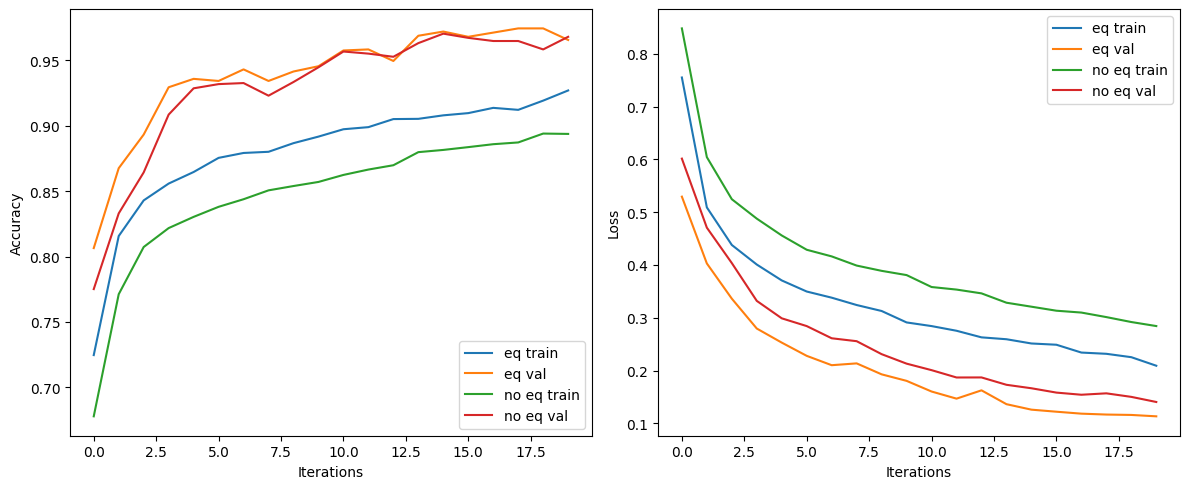

In [35]:
plotplz(performance_vgg16_eq,performance_vgg16) # Richiama la funzione plotplz per visualizzare i grafici del modello vgg16 equalizzato e non

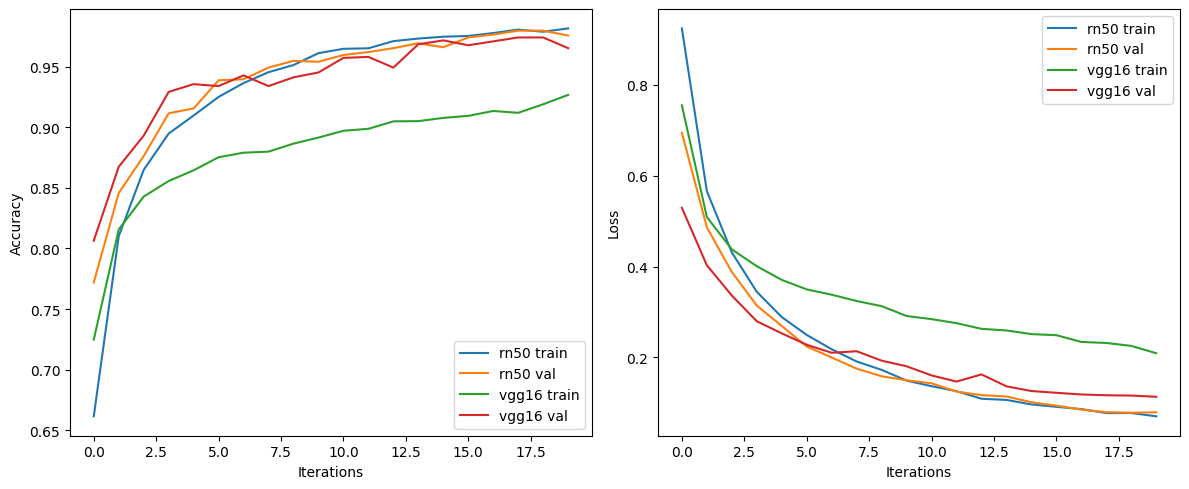

In [36]:
plotplz(performance_rn50_eq, performance_vgg16_eq, models=True) # Richiama la funzione plotplz per visualizzare i grafici dei modelli resnet50 e vgg16 equalizzati